In [5]:
import numpy as np
import pandas as pd
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import binom
from sklearn.metrics import confusion_matrix

import mle
import flmp
from libfunc import to_table_body

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [6]:
# get paths to data files
file_paths = glob("./data/*.txt")

# load all data into a single array
data = np.array([np.loadtxt(fname) for fname in file_paths])
N, M, K = data.shape

# define number of samples for each subject
n_samples = 24 

# number of samples for simulated data
N_SAMPLES = 100

# Model Distributions on Data with FLMP and MLE
Fit MLE and FLMP to the data, create the corresponding distribution and sample from these to create simulated data.

In [7]:
# compute parameters and generate samples
samples = {
    "FLMP": np.zeros((N, M, K)),
    "MLE": np.zeros((N, M, K))
}
params = []
for i, d in enumerate(data):
    # get parameters for MLE and FLMP fits
    _, c_A, c_V, std_A, std_V = mle.fit(np.ones(4), d, n_samples)
    _, tA, tV = flmp.fit(np.ones(K*2), d, n_samples, K)

    # save parameters
    params.append(np.concatenate([tA, tV, np.array([c_A, std_A, c_V, std_V])]))

    # sample from FLMP
    p_A, p_V, p_AV = flmp.compute_probs(tA, tV)
    samples["FLMP"][i] = binom.rvs(N_SAMPLES, np.vstack([p_A.T, p_V.T, p_AV]))
    
    # sample from MLE
    p_A, p_V, p_AV = mle.compute_probs(c_A, c_V, np.exp(std_A), np.exp(std_V))
    samples["MLE"][i]  = binom.rvs(N_SAMPLES, np.vstack([p_A.T, p_V.T, p_AV]))

# Fit FLMP and MLE on Simulated Data

In [8]:
tmp = {
    "Fitting Model": [],
    "Sampling Model": [], 
    "Subject": [],
    "NLL": []
}
for model in samples:
    for i, Subject in enumerate(samples[model]):
        # compute negative log-likelihood for MLE fit on both simulated data
        nll, _, _, _, _ = mle.fit(np.ones(4), Subject, N_SAMPLES)
        tmp["Fitting Model"].append("MLE")
        tmp["Sampling Model"].append(model)
        tmp["Subject"].append(f"{i+1}")
        tmp["NLL"].append(nll)
        
        # compute negative log-likelihood for FLMP fit on both simulated data
        nll, _, _ = flmp.fit(np.ones(K*2), Subject, N_SAMPLES, K)
        tmp["Fitting Model"].append("FLMP")
        tmp["Sampling Model"].append(model)
        tmp["Subject"].append(f"{i+1}")
        tmp["NLL"].append(nll)

In [9]:
df_fit = pd.DataFrame.from_dict(tmp)
df_fit.groupby("Subject").min()

,Fitting Model,Sampling Model,NLL
Subject,,,
1,FLMP,FLMP,67.174883
2,FLMP,FLMP,48.802427
3,FLMP,FLMP,72.907141
4,FLMP,FLMP,66.012688
5,FLMP,FLMP,54.982790


In [10]:
df_fit.groupby(["Sampling Model", "Subject"]).min()

Fitting Model        NLL
Sampling Model Subject                         
FLMP           1                FLMP  67.174883
               2                FLMP  48.802427
               3                FLMP  72.907141
               4                FLMP  68.533913
               5                FLMP  57.477361
MLE            1                FLMP  73.967529
               2                FLMP  51.931484
               3                FLMP  75.985683
               4                FLMP  66.012688
               5                FLMP  54.982790

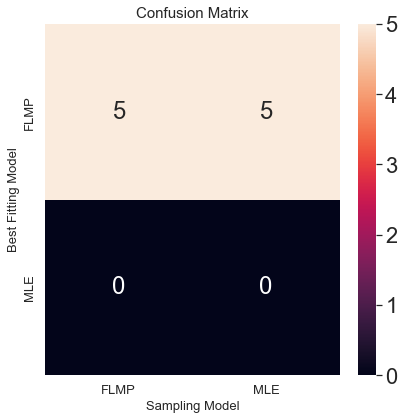

In [24]:
plot_options = {
    'annot': True,
    'xticklabels': ['FLMP', 'MLE'],
    'yticklabels': ['FLMP', 'MLE'],
}
y_true = ["FLMP"]*5 + ["MLE"]*5
y_pred = ["FLMP"]*10

# get confusion matrix and normalized confusion matrix
cm = confusion_matrix(y_true, y_pred).T
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# display confusion matrices
plt.figure(figsize=(6, 6))
sns.set(font_scale=1) 
sns.heatmap(cm, **plot_options)

plt.tick_params(axis='both', which='major', labelsize=13)  # Adjust to fit

plt.xlabel('Sampling Model', fontsize=13)
plt.ylabel('Best Fitting Model', fontsize=13)
plt.title('Confusion Matrix', fontsize=15)
plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches="tight")

# Print out stuff for Latex report

In [9]:
# print out parameters in latex format
print('Parameters for all subjects')
print(to_table_body(params))

# display data for a single subject
SUBJECT_NUMBER = 0
print(f"\nSimulated data for 'Subject {SUBJECT_NUMBER+1}'\n(ignore first column)")
print(to_table_body(np.hstack([
    samples['FLMP'][SUBJECT_NUMBER], 
    samples['MLE'][SUBJECT_NUMBER]
]), num_float=False).replace('Subject ', ''))

# extract dataframe for the single subject of negative log-likelihoods
print(f'\nNegative log-likelihoods for "Subject {SUBJECT_NUMBER+1}"')
df_fit_ = df_fit.reset_index()
df_fit_ = df_fit_[df_fit_['Subject'].astype(int) == SUBJECT_NUMBER + 1].set_index(["Fitting Model"])
df_fit_[df_fit_.columns[df_fit_.columns.isin(['Sampling Model', 'NLL'])]]

Parameters for all subjects
Subject 1 & -3.31 & -2.29 & -1.52 & 2.46 & 3.21 & -2.97 & 0.84 & 2.91 & 3.58 & 3.83 & 3.31 & -0.10 & 1.86 & -0.13\\
Subject 2 & -3.68 & -1.83 & -0.32 & 2.58 & 4.83 & -5.29 & 0.91 & 3.20 & 5.09 & 5.87 & 3.02 & -0.27 & 1.98 & -0.53\\
Subject 3 & -2.65 & -1.74 & -0.69 & 2.62 & 5.41 & -2.00 & 0.25 & 1.54 & 2.37 & 2.62 & 2.90 & -0.10 & 2.05 & 0.13\\
Subject 4 & -4.12 & -3.11 & -2.04 & 2.25 & 4.62 & -2.52 & -1.19 & -0.31 & 1.26 & 2.12 & 3.36 & -0.36 & 3.11 & 0.13\\
Subject 5 & -5.43 & -3.93 & -1.42 & 2.92 & 6.24 & -3.01 & 0.42 & 1.73 & 2.42 & 3.05 & 3.32 & -0.53 & 2.07 & -0.08

Simulated data for 'Subject 1'
(ignore first column)
1 & 2 & 13 & 27 & 97 & 98 & 0 & 6 & 32 & 73 & 100\\
2 & 4 & 75 & 90 & 96 & 98 & 24 & 63 & 91 & 98 & 100\\
3 & 0 & 1 & 3 & 37 & 49 & 0 & 7 & 10 & 30 & 75\\
4 & 9 & 15 & 34 & 95 & 98 & 1 & 24 & 48 & 83 & 90\\
5 & 35 & 58 & 75 & 100 & 100 & 22 & 49 & 74 & 91 & 100\\
6 & 49 & 81 & 90 & 100 & 100 & 47 & 72 & 94 & 100 & 100\\
7 & 55 & 88 & 91 &

,Sampling Model,NLL
Fitting Model,,
MLE,FLMP,194.757929
FLMP,FLMP,67.315285
MLE,MLE,78.309870
FLMP,MLE,86.126705
